### CS60050 MACHINE LEARNING <br> ASSIGNMENT 01 - DECISION TREE LEARNING <br> 19 SEPTMEBER 2021
***Amrta Chaurasia (19EE10004)***<br>***Nakul Aggarwal (19CS10044)***

In [1]:
import csv
from math import log2
from random import shuffle
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Back
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
# load dataset from the csv file whose location is provided as the arguement
def Load_Dataset ( loc ) :
    global attributes, data_samples
    attributes = data_samples = [ ]
    with open(loc) as csv_file :
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader :
            attributes = list(row)
            sample = row
            for att in attributes :
                try :
                    numerical_val = eval(row[att])
                    sample[att] = numerical_val
                except :
                    continue
            data_samples.append(sample)

In [3]:
# average of all the values of the attribute that are present in the datset
def Get_Mean_Attribue_Value ( att , target_value ) :
    global data_samples
    sum_att_value = 0
    count = 0
    for sample in data_samples :
        if ( sample[attributes[-1]] != target_value ) : continue
        try :
            sum_att_value += sample[att]
            count += 1
        except :
            continue
    return sum_att_value / count

# Some attribute values might be missing. Put the average value
# of that attribute in place of the missing value.
def Check_Missing_Attribute_Values ( ) :
    global data_samples
    for att in attributes[:-1] :
        distinct_values = set([ x[att] for x in data_samples ])
        if not '' in distinct_values : continue
        mean_attribute_value_for_liver_patients = Get_Mean_Attribue_Value(att, 1)
        mean_attribute_value_for_non_liver_patients = Get_Mean_Attribue_Value(att, 2)
        for sample in data_samples :
            if sample[att] != '' : continue
            if sample['is_patient'] == 1 :
                sample[att] = mean_attribute_value_for_liver_patients
            else :
                sample[att] = mean_attribute_value_for_non_liver_patients

In [4]:
# computes entropy given the positive samples count and negatve samples count
def Entropy ( pos_count , neg_count ) :
    if pos_count == 0 : return 0
    if neg_count == 0 : return 0
    p = pos_count / (pos_count + neg_count)
    n = neg_count / (pos_count + neg_count)
    return -1 * (p*log2(p) + n*log2(n))

# computes gini index given the positive samples count and negatve samples count
def Gini_Index ( pos_count , neg_count ) :
    if pos_count == 0 : return 0
    if neg_count == 0 : return 0
    p = pos_count / (pos_count + neg_count)
    n = neg_count / (pos_count + neg_count)
    return 2 * p * n

# for a set of examples and an attribute, if the attribute is discrete (gender) then it
# returns the information gain due to splitting on that attribute; otherwise if the attribute
# is continuous-valued it returns the best candidate threshold and the corresponding IG.
def Information_Gain ( examples , att ) :
    if att == 'gender' :
        total_pos = len([x for x in examples if x['is_patient'] == 1])
        total_neg = len(examples) - total_pos
        male_pos = len([x for x in examples if x['is_patient'] == 1 and x['gender'] == 'Male'])
        male_neg = len([x for x in examples if x['is_patient'] == 2 and x['gender'] == 'Male'])
        female_pos = total_pos - male_pos
        female_neg = total_neg - male_neg
        
        initial_entr = Entropy(total_pos, total_neg)
        male_entr = Entropy(male_pos, male_neg)
        female_entr = Entropy(female_pos, female_neg)
        
        male_frac = (male_pos + male_neg) / len(examples)
        female_frac = 1 - male_frac
        
        return (initial_entr - male_entr * male_frac - female_entr * female_frac, None)
    
    candidate_thresholds = set()
    sorted_examples = examples
    sorted_examples.sort(key = lambda x : x[att])
    
    prev_target = sorted_examples[0]['is_patient']
    prev_att_value = -1
    for sample in sorted_examples :
        if sample['is_patient'] == prev_target :
            prev_att_value = sample[att]
            continue
        candidate_thresholds.add((sample[att]+prev_att_value)/2)
        prev_target = sample['is_patient']
        prev_att_value = sample[att]
    
    max_info_gain = 0
    best_threshold = None
    
    total_pos = len([x for x in examples if x['is_patient'] == 1])
    total_neg = len(examples) - total_pos
    initial_entr = Entropy(total_pos, total_neg)
    
    for th in candidate_thresholds :
        less_than_pos = len([x for x in examples if x['is_patient'] == 1 and x[att] < th])
        less_than_neg = len([x for x in examples if x['is_patient'] == 2 and x[att] < th])
        more_than_pos = total_pos - less_than_pos
        more_than_neg = total_neg - less_than_neg
        
        less_than_entr = Entropy(less_than_pos, less_than_neg)
        more_than_entr = Entropy(more_than_pos, more_than_neg)
        
        less_frac = (less_than_pos + less_than_neg) / len(examples)
        more_frac = 1 - less_frac
        
        gain = initial_entr - less_than_entr * less_frac - more_than_entr * more_frac
        
        if gain > max_info_gain :
            max_info_gain = gain
            best_threshold = th
    
    return max_info_gain, best_threshold

# for a set of examples and an attribute, if the attribute is discrete (gender) then it
# returns the gain in gini index due to splitting on that attribute; otherwise if the attribute
# is continuous-valued it returns the best candidate threshold and the corresponding gini gain.
def Gini_Gain ( examples , att ) :
    if att == 'gender' :
        total_pos = len([x for x in examples if x['is_patient'] == 1])
        total_neg = len(examples) - total_pos
        male_pos = len([x for x in examples if x['is_patient'] == 1 and x['gender'] == 'Male'])
        male_neg = len([x for x in examples if x['is_patient'] == 2 and x['gender'] == 'Male'])
        female_pos = total_pos - male_pos
        female_neg = total_neg - male_neg
        
        initial_gi = Gini_Index(total_pos, total_neg)
        male_gi = Gini_Index(male_pos, male_neg)
        female_gi = Gini_Index(female_pos, female_neg)
        
        male_frac = (male_pos + male_neg) / len(examples)
        female_frac = 1 - male_frac
        
        return (initial_gi - male_gi * male_frac - female_gi * female_frac, None)
    
    candidate_thresholds = set()
    sorted_examples = examples
    sorted_examples.sort(key = lambda x : x[att])
    
    prev_target = sorted_examples[0]['is_patient']
    prev_att_value = -1
    for sample in sorted_examples :
        if sample['is_patient'] == prev_target :
            prev_att_value = sample[att]
            continue
        candidate_thresholds.add((sample[att]+prev_att_value)/2)
        prev_target = sample['is_patient']
        prev_att_value = sample[att]
    
    max_gini_gain = 0
    best_threshold = None
    
    total_pos = len([x for x in examples if x['is_patient'] == 1])
    total_neg = len(examples) - total_pos
    initial_gi = Gini_Index(total_pos, total_neg)
    
    for th in candidate_thresholds :
        less_than_pos = len([x for x in examples if x['is_patient'] == 1 and x[att] < th])
        less_than_neg = len([x for x in examples if x['is_patient'] == 2 and x[att] < th])
        more_than_pos = total_pos - less_than_pos
        more_than_neg = total_neg - less_than_neg
        
        less_than_gi = Gini_Index(less_than_pos, less_than_neg)
        more_than_gi = Gini_Index(more_than_pos, more_than_neg)
        
        less_frac = (less_than_pos + less_than_neg) / len(examples)
        more_frac = 1 - less_frac
        
        gain = initial_gi - less_than_gi * less_frac - more_than_gi * more_frac
        
        if gain > max_gini_gain :
            max_gini_gain = gain
            best_threshold = th
    
    return max_gini_gain, best_threshold

In [5]:
# +++ NODE +++
#     Class written for the nodes in the decision tree.
#     • Attributes
#         ID -- every node has a unique ID associated with it
#         EXAMPLES -- every node has a subset of training set sorted to it
#         CHILDREN -- every node has children (for leaf nodes CHILDREN is "None")
#         IS_PURE -- tells if all the examples associated with it belong to the same class
#         MAJORITY_CLASS -- tells the majority class among the examples associated with it
#         SPLITTING_ATTRIBUTE -- the attribute based on which the examples are further split
#         SPLITTING_ATTRIBUTE_THRESHOLD -- optimal candidate threshold for continuous-valued attributes
#                                          it is "None" for discrete valued attributes
#         IS_PRUNED -- tells if this node no longer exists in the decision tree or it does
#     • Member Function
#         COPY() -- creates a deep-copy of the node (all attributes are exactly the same for the copy)

class Node :
    def __init__ ( self , examples , node_id ) :
        self.id = node_id
        self.examples = examples
        self.children = None
        self.is_pure = None
        self.majority_class = None
        self.splitting_att = None
        self.splitting_att_thresh = None
        self.is_pruned = False
        
        pos_count = len([x for x in examples if x['is_patient'] == 1])
        neg_count = len(examples) - pos_count
        if pos_count == 0 or pos_count == len(examples) :
            self.is_pure = True
        else : self.is_pure = False
        
        if neg_count > pos_count :
            self.majority_class = 2
        else : self.majority_class = 1
    
    def copy ( self ) :
        n = Node([], 0)
        n.id = self.id
        n.examples = self.examples.copy()
        n.children = self.children
        n.is_pure = self.is_pure
        n.majority_class = self.majority_class
        n.splitting_att = self.splitting_att
        n.splitting_att_thresh = self.splitting_att_thresh
        n.is_pruned = self.is_pruned
        return n

In [6]:
# +++ DECISION TREE +++
#     Class written for the decision tree.
#     • Attributes
#         AVAILABLE_ID -- the smallest ID that is not alloted to any other node in the decision tree as of now.
#         ID_TO_NODE -- a list of all the nodes in the decision tree (ID_TO_NODE[x] is the node with its ID x)
#         TRAINING_HISTORY -- stores all the information related to the structural attributes and the prediction 
#                             abilities of the partially constructed tree while training
#                             (1.) stores the height of the tree after every iteration
#                             (2.) stores the size of the tree after every iteration
#                             (3.) stores the accuracy of the tree on the training data after every iteration
#                             (4.) stores the accuracy of the tree on the test data after every iteration
#                             (5.) stores the partially constructed decision-tree itself after every iteration
#     • Member Functions
#         ADD -- Add new node to the tree with the associated examples
#         SPLIT_BY_IG -- splits a given node based on the attribute that gives the highest information gain
#         SPLIT_BY_GINI -- splits a given node based on the attribute that gives the highest gini index gain
#         PRINT_TREE -- prints the tree with the hierarchical levels of splitting attributes in a 
#                       well-formatted and well-highlighted manner
#         HEIGHT -- returns the height of the tree
#         SIZE -- returns the size of the tree
#         PREDICT -- predicts the class for the instance passed as arguement
#         ACCURACY -- computes the accuracy of the tree on the given dataset
#         CONFUSION_MATRIX -- returns a 2-D confusion matrix for the given dataset
#         PRUNE -- prunes the decision tree in a recursive post-order manner using chi-square statistical testing
#         COPY -- creates a deep-copy of the tree (all attributes are exactly the same for the copy)

class Decision_Tree :
    def __init__ ( self ) :
        self.available_id = 0
        self.id_to_node = []
        self.training_history = {
            'height_progress' : [],
            'size_progress' : [],
            'train_accuracy_progress' : [],
            'test_accuracy_progress' : [],
            'tree_progress' : []
        }
        
    def add ( self , examples ) :
        new_node = Node(examples, self.available_id)
        self.id_to_node.append(new_node) 
        self.available_id += 1
        return new_node.id
    
    def split_by_ig ( self , node_id , attributes ) :
        if node_id >= len(self.id_to_node) : return []
        if ( self.id_to_node[node_id].is_pure ) : return []
        
        ig_for_best_att = -1
        threshold_for_best_att = None
        best_attribute = ''
        for att in attributes :
            gain, th = Information_Gain(self.id_to_node[node_id].examples, att)
            if gain > ig_for_best_att :
                ig_for_best_att = gain
                threshold_for_best_att = th
                best_attribute = att
        
        self.id_to_node[node_id].splitting_att = best_attribute
        
        if ( best_attribute == 'gender' ) :
            male_examples = [eg for eg in self.id_to_node[node_id].examples if eg['gender'] == 'Male']
            female_examples = [eg for eg in self.id_to_node[node_id].examples if eg['gender'] == 'Female']
            children = self.add(male_examples) , self.add(female_examples)
            self.id_to_node[node_id].children = children
            return children
        
        else :
            self.id_to_node[node_id].splitting_att_thresh = threshold_for_best_att
            less_than_examples = [eg for eg in self.id_to_node[node_id].examples 
                                      if eg[best_attribute] < threshold_for_best_att]
            more_than_examples = [eg for eg in self.id_to_node[node_id].examples 
                                      if eg[best_attribute] >= threshold_for_best_att]
            children = ( self.add(less_than_examples) , self.add(more_than_examples) )
            self.id_to_node[node_id].children = children
            return children
    
    def split_by_gini ( self , node_id , attributes ) :
        if node_id >= len(self.id_to_node) : return []
        if ( self.id_to_node[node_id].is_pure ) : return []
        
        gg_for_best_att = -1
        threshold_for_best_att = None
        best_attribute = ''
        for att in attributes :
            gain, th = Gini_Gain(self.id_to_node[node_id].examples, att)
            if gain > gg_for_best_att :
                gg_for_best_att = gain
                threshold_for_best_att = th
                best_attribute = att
        
        self.id_to_node[node_id].splitting_att = best_attribute
        
        if ( best_attribute == 'gender' ) :
            male_examples = [eg for eg in self.id_to_node[node_id].examples if eg['gender'] == 'Male']
            female_examples = [eg for eg in self.id_to_node[node_id].examples if eg['gender'] == 'Female']
            children = self.add(male_examples) , self.add(female_examples)
            self.id_to_node[node_id].children = children
            return children
        
        else :
            self.id_to_node[node_id].splitting_att_thresh = threshold_for_best_att
            less_than_examples = [eg for eg in self.id_to_node[node_id].examples 
                                      if eg[best_attribute] < threshold_for_best_att]
            more_than_examples = [eg for eg in self.id_to_node[node_id].examples 
                                      if eg[best_attribute] >= threshold_for_best_att]
            children = ( self.add(less_than_examples) , self.add(more_than_examples) )
            self.id_to_node[node_id].children = children
            return children
    
    def print_tree ( self , node_id = 0 , level = 0 , label = 'R' ) :
        node = self.id_to_node[node_id]
        print('--|'*level, end = '')
        print('->' + Back.BLACK + Fore.YELLOW + label + Fore.BLACK, end='')
        print(Back.RESET, end='')

        pos = len([x for x in node.examples if x['is_patient'] == 1])
        neg = len(node.examples) - pos

        print('('+str(pos)+'+', str(neg)+'-)', end='')

        if not node.splitting_att is None :
            if node.splitting_att == 'gender' :
                print('\033[1m' + '{GENDER = MALE}' + '\033[0m')
            else :
                print('\033[1m' + '{' + node.splitting_att.upper(), '<', 
                      str(round(node.splitting_att_thresh, 2)) + '}' + '\033[0m')
        else :
            if node.majority_class == 1 :
                print(Fore.MAGENTA + '\033[1m[LIVER PATIENT]\033[0m' + Fore.BLACK)
            else :
                print(Fore.MAGENTA + '\033[1m[NON LIVER PATIENT]\033[0m' + Fore.BLACK)

        if node.children is None : return
        self.print_tree(node.children[0], level+1, 'T')
        self.print_tree(node.children[1], level+1, 'F')
    
    def height ( self , node_id = 0 ) :
        if self.id_to_node[node_id].children is None : return 0
        h = 0
        for child in self.id_to_node[node_id].children :
            h = max(h, self.height(child))
        return h + 1

    def size ( self , node_id = 0 ) :
        if self.id_to_node[node_id].children is None : return 1
        s = 1
        for child in self.id_to_node[node_id].children :
            s += self.size(child)
        return s
    
    def predict ( self , instance , node_id = 0 ) :
        node = self.id_to_node[node_id]
        if ( node.children is None ) : return node.majority_class

        if ( node.splitting_att == 'gender' ) :
            if instance['gender'] == 'Male' :
                return self.predict(instance, node.children[0])
            else :
                return self.predict(instance, node.children[1])

        else :
            if instance[node.splitting_att] < node.splitting_att_thresh :
                return self.predict(instance, node.children[0])
            else :
                return self.predict(instance, node.children[1])
    
    def accuracy ( self , test_set ) :
        correctly_predicted = 0
        for example in test_set :
            pred = self.predict(example)
            true = example['is_patient']
            correctly_predicted += (pred == true)
        return 100 * correctly_predicted / len(test_set)
    
    def confusion_matrix ( self , test_data ) :
        true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
        for example in test_set :
            pred = self.predict(example)
            true = example['is_patient']
            if true == 1 :
                true_pos += (true == pred)
                false_neg += (true != pred)
            else :
                true_neg += (true == pred)
                false_pos += (true != pred)
        return np.array([[true_pos, false_pos], [false_neg, true_neg]])
    
    def prune ( self , threshold = 0.5 , node_id = 0 , verbose = False ) :
        node = self.id_to_node[node_id]
        if ( node.children is None ) : return

        for child in node.children :
            self.prune(threshold, child, verbose)
        
        if len(node.children) == 2 :
            child1 = self.id_to_node[node.children[0]]
            child2 = self.id_to_node[node.children[1]]
            if child1.children is None and child2.children is None :
                if child1.majority_class == child2.majority_class :
                    child1.is_pruned = child2.is_pruned = True
                    self.id_to_node[node_id].children = None
                    self.id_to_node[node_id].splitting_att = None
                    self.id_to_node[node_id].splitting_att_thresh = None
                    return

        left_pos, left_neg, right_pos, right_neg = 0, 0, 0, 0

        for eg in node.examples :
            is_pos = (eg['is_patient'] == 1)
            if node.splitting_att == 'gender' :
                if eg['gender'] == 'Male' : 
                    left_pos += is_pos
                    left_neg += not is_pos
                else :
                    right_pos += is_pos
                    right_neg += not is_pos
            else :
                if eg[node.splitting_att] < node.splitting_att_thresh : 
                    left_pos += is_pos
                    left_neg += not is_pos
                else :
                    right_pos += is_pos
                    right_neg += not is_pos

        pos = left_pos + right_pos
        neg = len(node.examples) - pos
        prob_left = (left_pos + left_neg) / len(node.examples)
        prob_right = 1 - prob_left
        K_left_pos = ((left_pos - pos*prob_left) ** 2) / (pos*prob_left)
        K_left_neg = ((left_neg - neg*prob_left) ** 2) / (neg*prob_left)
        K_right_pos = ((right_pos - pos*prob_right) ** 2) / (pos*prob_right)
        K_right_neg = ((right_neg - neg*prob_right) ** 2) / (neg*prob_right)
        K = K_left_pos + K_left_neg + K_right_pos + K_right_neg
        
        if verbose : print(node_id, K)
    
        if K >= threshold : return

        for child in node.children :
            self.id_to_node[child].is_pruned = True

        self.id_to_node[node_id].children = None
        self.id_to_node[node_id].splitting_att = None
        self.id_to_node[node_id].splitting_att_thresh = None
        return
    
    def copy ( self ) :
        dt = Decision_Tree()
        dt.available_id = self.available_id
        dt.training_history = self.training_history.copy()
        dt.id_to_node = [ n.copy() for n in self.id_to_node ]
        return dt

In [7]:
# constructs the decision tree on the training set while keeping track of the training history;
# if the use_gini_impurity_measure is False then information gain is used as the impurity measure
# and gini index gain otherwise; the tree is constructed in a breadth-first-search traversal by
# maintaining a queue of the un-splitted nodes
def Construct_Tree ( train_set , test_set , use_gini_impurity_measure = False ) :
    decision_tree = Decision_Tree()
    root_id = decision_tree.add(train_set)
    bfs_queue = [ root_id ]
    
    decision_tree.training_history['height_progress'].append(decision_tree.height())
    decision_tree.training_history['size_progress'].append(decision_tree.size())
    decision_tree.training_history['test_accuracy_progress'].append(decision_tree.accuracy(test_set))
    decision_tree.training_history['train_accuracy_progress'].append(decision_tree.accuracy(train_set))
    decision_tree.training_history['tree_progress'].append(decision_tree.copy())
    
    while len(bfs_queue) > 0 :
        child_nodes = None
        if not use_gini_impurity_measure :
            child_nodes = decision_tree.split_by_ig(bfs_queue[0], attributes)
        else :
            child_nodes = decision_tree.split_by_gini(bfs_queue[0], attributes)
        bfs_queue.pop(0)
        bfs_queue.extend(child_nodes)
        
        if len(child_nodes) > 0 :
            decision_tree.training_history['height_progress'].append(decision_tree.height())
            decision_tree.training_history['size_progress'].append(decision_tree.size())
            decision_tree.training_history['test_accuracy_progress'].append(decision_tree.accuracy(test_set))
            decision_tree.training_history['train_accuracy_progress'].append(decision_tree.accuracy(train_set))
            decision_tree.training_history['tree_progress'].append(decision_tree.copy())
    
    return decision_tree

In [8]:
# do a random 80/20 split on the data samples and
# return the resulting train and test sets
def Random_Split ( ) :
    global data_samples
    shuffle(data_samples)
    test_size = round(0.2 * len(data_samples))
    test = data_samples[:test_size]
    train = data_samples[test_size:]
    return train, test

In [9]:
# Resampling of the Original Dataset (read the report for theoretical details)
# Oversamples the original dataset using Synthetic Minority Oversampling Technique
# Merges a fraction of synthetically produced minority class examples with the original dataset
def Resample_Dataset ( ) :
    global data_samples
    sm = SMOTE(random_state = 42)
    
    Y = [list(p.values())[-1] for p in data_samples]
    X = [list(p.values())[:-1] for p in data_samples]
    for p in X : 
        p[1] = (p[1] == 'Male') * 1
    
    X = np.array(X)
    X, Y = sm.fit_resample(X, Y)
    l = X.shape[0]
    
    resampled_data_samples = []
    for s in range(l) :
        if Y[s] == 1 : continue
        sample = dict()
        for i, att in enumerate(attributes) :
            sample[att] = X[s][i]
            if i == 1 :
                sample[att] = round(sample[att])
                if sample[att] == 1 : sample[att] = 'Male'
                else : sample[att] = 'Female'
        sample['is_patient'] = Y[s]
        resampled_data_samples.append(sample)
    
    pos = len([p for p in data_samples if p['is_patient'] == 1])
    deficit = 2 * pos - len(data_samples)
    oversampling = int(0.5 * deficit)
    
    shuffle(resampled_data_samples)
    data_samples += resampled_data_samples[:oversampling]

In [10]:
# plots a consfusion matrix as a seaborn heatmap and saves it as an image in the given location
def Plot_And_Save_Confusion_Matrix ( cf , loc ) :
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    categories = ['Liver Patient', 'Non Liver Patient']

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cf/np.sum(cf), annot=labels, fmt='', cmap='flare')

    ax.set_xlabel('TRUE LABELS', fontsize=15)
    ax.set_ylabel('PREDICTED LABELS', fontsize=15)
    ax.xaxis.set_ticklabels(['Patient', 'Non Patient'], fontsize=13, va="center")
    ax.yaxis.set_ticklabels(['Patient', 'Non Patient'], fontsize=13, va="center")

    plt.show()
    fig.savefig(loc)

In [11]:
# load dataset, check for missing attribute values and perform resampling
Load_Dataset('ILPD.csv')
Check_Missing_Attribute_Values()
attributes = attributes[:-1]
Resample_Dataset()

### PART 01
Decision tree classifiers are built on a randomly 80/20 split dataset, using gini index and information gain as the impurity measures. The impact of using the individual impurity measures is analyzed by their prediction accuracies and some structural properties of the resultant decision trees.

The re-sampled dataset is randomly split into 80% training set and 20% testing set. Two decision trees are trained, both on the same training data. One of them uses information gain as the impurity measure to choose the best splitting attribute at every internal node and the other uses gain in the gini index. The accuracies of the trees are computed on the same test data. Besides accuracy, the height, size and training time for the two decision trees are also compared to deduce some informative results.

In [12]:
train_set, test_set = Random_Split()
start = time()
tree_ig = Construct_Tree(train_set, test_set, use_gini_impurity_measure = False)
train_time_ig = time() - start
start = time()
tree_gg = Construct_Tree(train_set, test_set, use_gini_impurity_measure = True)
train_time_gg = time() - start

In [13]:
print('ACCURACY OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE :', tree_gg.accuracy(test_set))
print('ACCURACY OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE :', tree_ig.accuracy(test_set))

print('SIZE OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE :', tree_gg.size())
print('SIZE OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE :', tree_ig.size())

print('HEIGHT OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE :', tree_gg.height())
print('HEIGHT OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE :', tree_ig.height())

print('TIME TO CONSTRUCT DECISION TREE WITH GINI IMPURITY MEASURE (secs) :', round(train_time_gg, 4))
print('TIME TO CONSTRUCT DECISION TREE WITH INFORMATION GAIN MEASURE (secs) :', round(train_time_ig, 4))

ACCURACY OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE : 76.59574468085107
ACCURACY OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE : 82.26950354609929
SIZE OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE : 195
SIZE OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE : 203
HEIGHT OF DECISION TREE BUILT WITH GINI IMPURITY MEASURE : 21
HEIGHT OF DECISION TREE BUILT WITH INFORMATION GAIN MEASURE : 24
TIME TO CONSTRUCT DECISION TREE WITH GINI IMPURITY MEASURE (secs) : 0.5667
TIME TO CONSTRUCT DECISION TREE WITH INFORMATION GAIN MEASURE (secs) : 0.7101


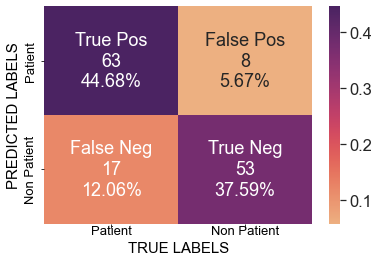

In [14]:
cf = tree_ig.confusion_matrix(test_set)
Plot_And_Save_Confusion_Matrix(cf, 'cf1.png')

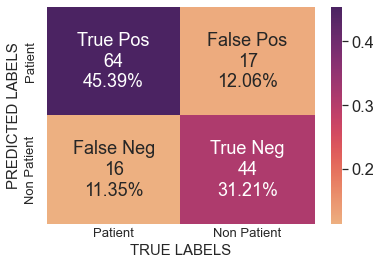

In [15]:
cf = tree_gg.confusion_matrix(test_set)
Plot_And_Save_Confusion_Matrix(cf, 'cf2.png')

In [18]:
# printing the trees just for an intuition that how similar do they actually look
tree_gg.print_tree()

->R(340+ 326-){DIRECT_BILIRUBIN < 0.89}
--|->T(191+ 305-){TOT_PROTEINS < 205.0}
--|--|->T(90+ 237-){ALBUMIN < 93.5}
--|--|--|->T(85+ 237-){AGE < 30.99}
--|--|--|--|->T(9+ 72-){AG_RATIO < 12.5}
--|--|--|--|--|->T(2+ 0-)[LIVER PATIENT]
--|--|--|--|--|->F(7+ 72-){SGPT < 8.0}
--|--|--|--|--|--|->T(4+ 69-){SGPT < 3.25}
--|--|--|--|--|--|--|->T(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|->F(3+ 69-){SGOT < 4.55}
--|--|--|--|--|--|--|--|->T(2+ 69-){TOT_PROTEINS < 185.68}
--|--|--|--|--|--|--|--|--|->T(0+ 53-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(2+ 16-){DIRECT_BILIRUBIN < 0.14}
--|--|--|--|--|--|--|--|--|--|->T(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|--|->F(1+ 16-){ALKPHOS < 1.28}
--|--|--|--|--|--|--|--|--|--|--|->T(0+ 16-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|->F(3+ 3-){TOT_BILIRUBIN < 1.15}
--|--|--|--|--|--|--|->T(3+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|->F(

In [19]:
tree_ig.print_tree()

->R(340+ 326-){DIRECT_BILIRUBIN < 0.89}
--|->T(191+ 305-){TOT_PROTEINS < 205.0}
--|--|->T(90+ 237-){ALBUMIN < 93.5}
--|--|--|->T(85+ 237-){AGE < 30.99}
--|--|--|--|->T(9+ 72-){AG_RATIO < 12.5}
--|--|--|--|--|->T(2+ 0-)[LIVER PATIENT]
--|--|--|--|--|->F(7+ 72-){DIRECT_BILIRUBIN < 0.2}
--|--|--|--|--|--|->T(7+ 30-){SGPT < 7.93}
--|--|--|--|--|--|--|->T(4+ 30-){ALKPHOS < 1.3}
--|--|--|--|--|--|--|--|->T(1+ 26-){ALBUMIN < 25.02}
--|--|--|--|--|--|--|--|--|->T(1+ 8-){ALBUMIN < 24.87}
--|--|--|--|--|--|--|--|--|--|->T(0+ 8-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(0+ 18-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(3+ 4-){DIRECT_BILIRUBIN < 0.17}
--|--|--|--|--|--|--|--|--|->T(1+ 4-){TOT_PROTEINS < 125.0}
--|--|--|--|--|--|--|--|--|--|->T(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|--|->F(0+ 4-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(2+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|->F(3+ 0-)[LIVER PATIENT]
--|--|

### PART 02
Accuracies are provided for decision trees built on information gain and gini index impurity measures by averaging them over 10 random 80/20 splits. The best tree (the one with the highest test accuracy) is selected for the following parts.

Do 20 random 80/20 splits on the dataset. On the first ten splits, train ten distinct decision trees with gini index as the impurity measure and evaluate their performances on their respective test sets. For each of the trees, also compute their height, size and training times. Finally compute the average test accuracy, average depth, average size and average training time over ten random splits. Also keep track of the highest test accuracy observed, the tree for which the highest test accuracy was observed, the least depth, the least size and the least training time observed. 
Repeat these steps for the next ten splits with information gain as the impurity measure. Compare the best trees (ones with highest test accuracies) obtained in the two cases and select the better one.

In [20]:
all_trees = []

avg_accuracy_ig = 0
avg_height_ig = 0
avg_size_ig = 0
avg_time_ig = 0

best_accuracy_ig = 0
best_height_ig = float('inf')
best_size_ig = float('inf')
best_time_ig = float('inf')

best_tree_test_set_ig = None
best_tree_cf_mat_ig = None
most_accurate_tree_ig = None

for split in range(10) :
    train_set, test_set = Random_Split()
    start = time()
    tree_ig = Construct_Tree(train_set, test_set, use_gini_impurity_measure = False)
    t = time() - start
    acc = tree_ig.accuracy(test_set)
    if acc > best_accuracy_ig :
        best_accuracy_ig = acc
        most_accurate_tree_ig = tree_ig
        best_tree_cf_mat_ig = tree_ig.confusion_matrix(test_set)
        best_tree_test_set_ig = test_set
    
    avg_accuracy_ig += acc
    h, s = tree_ig.height(), tree_ig.size()
    avg_height_ig += h
    avg_size_ig += s
    avg_time_ig += t
    
    best_height_ig = min(best_height_ig, h)
    best_size_ig = min(best_size_ig, s)
    best_time_ig = min(best_time_ig, t)
    
    all_trees.append(tree_ig)

avg_accuracy_ig /= 10
avg_height_ig /= 10
avg_size_ig /= 10
avg_time_ig /= 10

In [21]:
avg_accuracy_gg = 0
avg_height_gg = 0
avg_size_gg = 0
avg_time_gg = 0

best_accuracy_gg = 0
best_height_gg = float('inf')
best_size_gg = float('inf')
best_time_gg = float('inf')

best_tree_test_set_gg = None
best_tree_cf_mat_gg = None
most_accurate_tree_gg = None

for split in range(10) :
    train_set, test_set = Random_Split()
    start = time()
    tree_gg = Construct_Tree(train_set, test_set, use_gini_impurity_measure = True)
    t = time() - start
    acc = tree_gg.accuracy(test_set)
    if acc > best_accuracy_gg :
        best_accuracy_gg = acc
        most_accurate_tree_gg = tree_gg
        best_tree_cf_mat_gg = tree_gg.confusion_matrix(test_set)
        best_tree_test_set_gg = test_set
    
    avg_accuracy_gg += acc
    h, s = tree_gg.height(), tree_gg.size()
    avg_height_gg += h
    avg_size_gg += s
    avg_time_gg += t
    
    best_height_gg = min(best_height_gg, h)
    best_size_gg = min(best_size_gg, s)
    best_time_gg = min(best_time_gg, t)
    
    all_trees.append(tree_gg)

avg_accuracy_gg /= 10
avg_height_gg /= 10
avg_size_gg /= 10
avg_time_gg /= 10

In [22]:
print('AVG. ACCURACY (GINI IMPURITY MEASURE) :', avg_accuracy_gg)
print('AVG. HEIGHT (GINI IMPURITY MEASURE) :', avg_height_gg)
print('AVG. SIZE (GINI IMPURITY MEASURE) :', avg_size_gg)
print('AVG. TRAINING TIME (GINI IMPURITY MEASURE) :', avg_time_gg)

print('BEST ACCURACY (GINI IMPURITY MEASURE) :', best_accuracy_gg)
print('BEST HEIGHT (GINI IMPURITY MEASURE) :', best_height_gg)
print('BEST SIZE (GINI IMPURITY MEASURE) :', best_size_gg)
print('BEST TRAINING TIME (GINI IMPURITY MEASURE) :', best_time_gg)

AVG. ACCURACY (GINI IMPURITY MEASURE) : 73.75886524822695
AVG. HEIGHT (GINI IMPURITY MEASURE) : 18.9
AVG. SIZE (GINI IMPURITY MEASURE) : 211.6
AVG. TRAINING TIME (GINI IMPURITY MEASURE) : 0.5856430768966675
BEST ACCURACY (GINI IMPURITY MEASURE) : 80.1418439716312
BEST HEIGHT (GINI IMPURITY MEASURE) : 15
BEST SIZE (GINI IMPURITY MEASURE) : 199
BEST TRAINING TIME (GINI IMPURITY MEASURE) : 0.5194697380065918


In [23]:
print('AVG. ACCURACY (IG IMPURITY MEASURE) :', avg_accuracy_ig)
print('AVG. HEIGHT (IG IMPURITY MEASURE) :', avg_height_ig)
print('AVG. SIZE (IG IMPURITY MEASURE) :', avg_size_ig)
print('AVG. TRAINING TIME (IG IMPURITY MEASURE) :', avg_time_ig)

print('BEST ACCURACY (IG IMPURITY MEASURE) :', best_accuracy_ig)
print('BEST HEIGHT (IG IMPURITY MEASURE) :', best_height_ig)
print('BEST SIZE (IG IMPURITY MEASURE) :', best_size_ig)
print('BEST TRAINING TIME (IG IMPURITY MEASURE) :', best_time_ig)

AVG. ACCURACY (IG IMPURITY MEASURE) : 73.82978723404256
AVG. HEIGHT (IG IMPURITY MEASURE) : 20.3
AVG. SIZE (IG IMPURITY MEASURE) : 190.8
AVG. TRAINING TIME (IG IMPURITY MEASURE) : 0.6182325601577758
BEST ACCURACY (IG IMPURITY MEASURE) : 79.43262411347517
BEST HEIGHT (IG IMPURITY MEASURE) : 15
BEST SIZE (IG IMPURITY MEASURE) : 179
BEST TRAINING TIME (IG IMPURITY MEASURE) : 0.5162041187286377


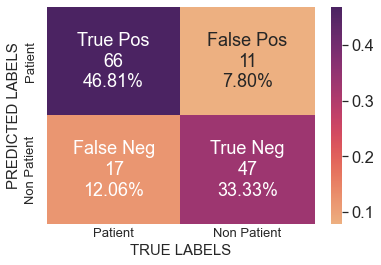

In [25]:
Plot_And_Save_Confusion_Matrix(best_tree_cf_mat_gg, 'cf3.png')

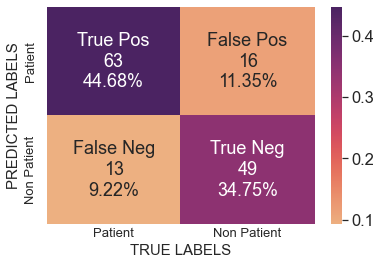

In [26]:
Plot_And_Save_Confusion_Matrix(best_tree_cf_mat_ig, 'cf4.png')

In [27]:
best_tree = None
best_tree_test_set = None
if best_accuracy_ig > best_accuracy_gg :
    best_tree = most_accurate_tree_ig
    best_tree_test_set = best_tree_test_set_ig
else :
    best_tree = most_accurate_tree_gg
    best_tree_test_set = best_tree_test_set_gg

### PART 03
The best depth limit for the dataset is computed and its value justified with a plot. A plot of the test accuracy vs the total number of nodes in the tree is also provided.

Build 20 decision trees on 20 random 80/20 splits of dataset, with half constructed on information gain and other half on gini index as the impurity measure (used the 20 trees constructed in the second part). To find the best depth in terms of the test accuracy, explore the training histories of each of the 20 trees (training history of a tree keeps track of the test and train accuracy of partially constructed trees vs the intermediate depth and size of the tree while training) and find for every possible height, the highest observed test accuracy across all the trees. Tabulate the highest observed test accuracy vs depth data points and plot them on a graph. Locate the global maxima on the plot. Repeat the steps to find for every possible tree size, the highest observed test accuracy across all the trees. Plot their data points on a separate graph.

In [29]:
highest_overall_test_acc = -1
tree_with_optimal_depth = None
best_accuracy_vs_height = dict()
for tree in all_trees :
    for idx, h in enumerate(tree.training_history['height_progress']) :
        if not h in best_accuracy_vs_height :
            best_accuracy_vs_height[h] = tree.training_history['test_accuracy_progress'][idx]
        else :
            best_accuracy_vs_height[h] = max(best_accuracy_vs_height[h],
                                                tree.training_history['test_accuracy_progress'][idx])
        if tree.training_history['test_accuracy_progress'][idx] > highest_overall_test_acc :
            highest_overall_test_acc = tree.training_history['test_accuracy_progress'][idx]
            tree_with_optimal_depth = tree.training_history['tree_progress'][idx]

print('OPTIMAL DEPTH LIMIT FOR THIS DATASET :', tree_with_optimal_depth.height())

OPTIMAL DEPTH LIMIT FOR THIS DATASET : 12


In [30]:
best_accuracy_vs_height

{0: 65.95744680851064,
 1: 63.829787234042556,
 2: 73.04964539007092,
 3: 74.46808510638297,
 4: 75.177304964539,
 5: 75.177304964539,
 6: 76.59574468085107,
 7: 78.01418439716312,
 8: 79.43262411347517,
 9: 80.85106382978724,
 10: 80.85106382978724,
 11: 80.85106382978724,
 12: 82.26950354609929,
 13: 80.85106382978724,
 14: 79.43262411347517,
 15: 81.56028368794327,
 16: 81.56028368794327,
 17: 80.1418439716312,
 18: 79.43262411347517,
 19: 79.43262411347517,
 20: 79.43262411347517,
 21: 79.43262411347517,
 22: 80.1418439716312,
 23: 73.75886524822695,
 24: 72.34042553191489,
 25: 75.177304964539,
 26: 73.04964539007092,
 27: 73.75886524822695,
 28: 73.04964539007092,
 29: 74.46808510638297}


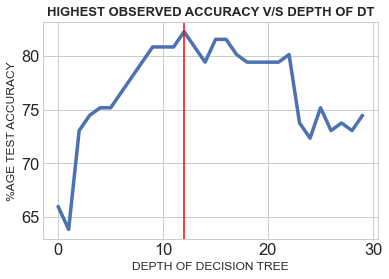

In [36]:
fontsize=12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(best_accuracy_vs_height.keys(), best_accuracy_vs_height.values(), linewidth=3.5)
plt.xlabel('DEPTH OF DECISION TREE', fontsize=fontsize)
plt.ylabel('%AGE TEST ACCURACY', fontsize=fontsize)
plt.title('HIGHEST OBSERVED ACCURACY V/S DEPTH OF DT', fontsize=13, fontweight='bold')
plt.axvline(x = 12, color = 'red')
plt.savefig('plot_height.png')

In [34]:
best_accuracy_vs_size = dict()
for tree in all_trees :
    for idx, s in enumerate(tree.training_history['size_progress']) :
        if not s in best_accuracy_vs_size :
            best_accuracy_vs_size[s] = tree.training_history['test_accuracy_progress'][idx]
        else :
            best_accuracy_vs_size[s] = max(best_accuracy_vs_size[s],
                                                tree.training_history['test_accuracy_progress'][idx])

In [35]:
best_accuracy_vs_size

{1: 65.95744680851064,
 3: 63.829787234042556,
 5: 73.04964539007092,
 7: 73.04964539007092,
 9: 73.04964539007092,
 11: 74.46808510638297,
 13: 73.04964539007092,
 15: 73.04964539007092,
 17: 75.177304964539,
 19: 75.177304964539,
 21: 74.46808510638297,
 23: 74.46808510638297,
 25: 74.46808510638297,
 27: 73.75886524822695,
 29: 73.75886524822695,
 31: 74.46808510638297,
 33: 74.46808510638297,
 35: 74.46808510638297,
 37: 75.177304964539,
 39: 75.177304964539,
 41: 75.177304964539,
 43: 75.177304964539,
 45: 75.177304964539,
 47: 74.46808510638297,
 49: 74.46808510638297,
 51: 74.46808510638297,
 53: 74.46808510638297,
 55: 75.177304964539,
 57: 75.177304964539,
 59: 76.59574468085107,
 61: 76.59574468085107,
 63: 76.59574468085107,
 65: 76.59574468085107,
 67: 75.177304964539,
 69: 75.177304964539,
 71: 75.88652482269504,
 73: 75.88652482269504,
 75: 76.59574468085107,
 77: 76.59574468085107,
 79: 77.30496453900709,
 81: 77.30496453900709,
 83: 78.01418439716312,
 85: 77.3049645390

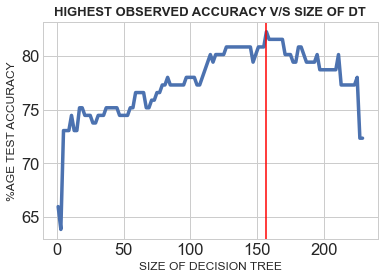

In [38]:
fontsize=12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(best_accuracy_vs_size.keys(), best_accuracy_vs_size.values(), linewidth=3.5)
plt.xlabel('SIZE OF DECISION TREE', fontsize=fontsize)
plt.ylabel('%AGE TEST ACCURACY', fontsize=fontsize)
plt.title('HIGHEST OBSERVED ACCURACY V/S SIZE OF DT', fontsize=13, fontweight='bold')
plt.axvline(x = 157, color = 'red')
plt.savefig('plot_size.png')

### PART 04
The tree with the highest test accuracy obtained in the second part was pruned using a valid statistical test for comparison.

Write a recursive member function for the Decision_Tree class that conducts ꭓ2 statistical test on  the internal nodes of the tree in a post-order fashion, i.e, the child nodes must be checked for pruning before the parent nodes. 
Find the optimal value of the threshold (within some predefined bounds) by pruning copies of the original tree with variable thresholds, while incrementing the threshold by a small value at every iteration. Choose the threshold that produces the tree with the maximum test accuracy.
Select the tree produced by pruning the original tree with the most optimal threshold value. Compare the structural attributes and the accuracies of the trees before and after pruning.

In [39]:
test_set = best_tree_test_set
best_tree_pruned = best_tree.copy()

In [40]:
thresh = 0.1
optimal_threshold = None
highest_pruned_tree_accuracy = -1
while thresh <= 10 :
    tree = best_tree.copy()
    tree.prune(threshold = thresh)
    acc = tree.accuracy(test_set)
    if highest_pruned_tree_accuracy < acc :
        highest_pruned_tree_accuracy = acc
        optimal_threshold = thresh
    print('THRESHOLD :', round(thresh, 1), ' | ACCURACY :', round(acc, 3) )
    thresh += 0.1

THRESHOLD : 0.1  | ACCURACY : 80.142
THRESHOLD : 0.2  | ACCURACY : 80.142
THRESHOLD : 0.3  | ACCURACY : 80.142
THRESHOLD : 0.4  | ACCURACY : 80.142
THRESHOLD : 0.5  | ACCURACY : 80.142
THRESHOLD : 0.6  | ACCURACY : 80.142
THRESHOLD : 0.7  | ACCURACY : 80.142
THRESHOLD : 0.8  | ACCURACY : 80.142
THRESHOLD : 0.9  | ACCURACY : 80.142
THRESHOLD : 1.0  | ACCURACY : 80.142
THRESHOLD : 1.1  | ACCURACY : 80.142
THRESHOLD : 1.2  | ACCURACY : 80.142
THRESHOLD : 1.3  | ACCURACY : 80.142
THRESHOLD : 1.4  | ACCURACY : 80.142
THRESHOLD : 1.5  | ACCURACY : 80.142
THRESHOLD : 1.6  | ACCURACY : 80.142
THRESHOLD : 1.7  | ACCURACY : 80.142
THRESHOLD : 1.8  | ACCURACY : 80.142
THRESHOLD : 1.9  | ACCURACY : 80.142
THRESHOLD : 2.0  | ACCURACY : 80.851
THRESHOLD : 2.1  | ACCURACY : 80.851
THRESHOLD : 2.2  | ACCURACY : 79.433
THRESHOLD : 2.3  | ACCURACY : 79.433
THRESHOLD : 2.4  | ACCURACY : 79.433
THRESHOLD : 2.5  | ACCURACY : 79.433
THRESHOLD : 2.6  | ACCURACY : 79.433
THRESHOLD : 2.7  | ACCURACY : 80.851
T

In [42]:
best_tree_pruned.prune(threshold = optimal_threshold)

In [43]:
training_set = best_tree.id_to_node[0].examples
print('TEST ACCURACY OF DECISION TREE AFTER PRUNING :', best_tree_pruned.accuracy(test_set))
print('TEST ACCURACY OF DECISION TREE BEFORE PRUNING :', best_tree.accuracy(test_set))
print('TEST ACCURACY OF DECISION TREE AFTER PRUNING :', best_tree_pruned.accuracy(training_set))
print('TRAIN ACCURACY OF DECISION TREE BEFORE PRUNING :', best_tree.accuracy(training_set))

TEST ACCURACY OF DECISION TREE AFTER PRUNING : 82.26950354609929
TEST ACCURACY OF DECISION TREE BEFORE PRUNING : 80.1418439716312
TEST ACCURACY OF DECISION TREE AFTER PRUNING : 95.93639575971731
TRAIN ACCURACY OF DECISION TREE BEFORE PRUNING : 100.0


In [44]:
print('DEPTH OF PRUNED DECISION TREE :', best_tree_pruned.height())
print('DEPTH OF ORIGINAL DECISION TREE ', best_tree.height())
print('SIZE OF PRUNED DECISION TREE :', best_tree_pruned.size())
print('SIZE OF ORIGINAL DECISION TREE ', best_tree.size())

DEPTH OF PRUNED DECISION TREE : 18
DEPTH OF ORIGINAL DECISION TREE  22
SIZE OF PRUNED DECISION TREE : 157
SIZE OF ORIGINAL DECISION TREE  211


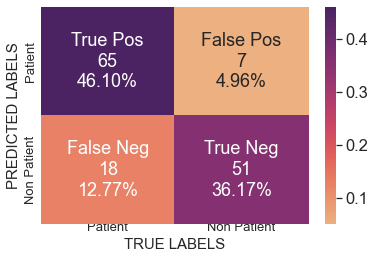

In [45]:
Plot_And_Save_Confusion_Matrix(best_tree_pruned.confusion_matrix(test_set), 'cf5.png')

### PART 05
The final trees obtained in the second (best tree without pruning), third (tree with the most optimal depth) and fourth (best tree after pruning) parts are printed adhering to the protocols stated in the procedure below.

Write a recursive member function for the Decision_Tree class that for each and every node prints the following in a well formatted manner such that its distance from the left margin is proportional to the hierarchical level of the tree.
- The number of positive and negative training examples associated with this node.
- A code ({R, T, F}) that reflects the condition to arrive at this node. R indicates a root node, T indicates that this node will be reached if the splitting condition in its parent node is true and similarly F indicates it will be reached if the condition is false. 
- For a leaf node, the class label must be written. For an internal node, the splitting condition must be written.

*Due to a lot of queries and confusion among the students surrounding the tree that should be printed in this part, we decided to print the final trees obtained in all the second, third and fourth parts.*

In [28]:
best_tree.print_tree() # printing the best tree obtained in second part

->R(330+ 336-){DIRECT_BILIRUBIN < 1.0}
--|->T(202+ 312-){ALBUMIN < 61.53}
--|--|->T(159+ 303-){TOT_PROTEINS < 217.94}
--|--|--|->T(106+ 259-){AGE < 71.62}
--|--|--|--|->T(94+ 257-){SGPT < 5.11}
--|--|--|--|--|->T(14+ 14-){TOT_BILIRUBIN < 1.05}
--|--|--|--|--|--|->T(14+ 7-){GENDER = MALE}
--|--|--|--|--|--|--|->T(13+ 3-){AG_RATIO < 103.5}
--|--|--|--|--|--|--|--|->T(12+ 1-){TOT_PROTEINS < 208.0}
--|--|--|--|--|--|--|--|--|->T(11+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(1+ 1-){AGE < 52.5}
--|--|--|--|--|--|--|--|--|--|->T(0+ 1-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(1+ 2-){AGE < 60.0}
--|--|--|--|--|--|--|--|--|->T(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(0+ 2-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|->F(1+ 4-){AGE < 49.0}
--|--|--|--|--|--|--|--|->T(0+ 4-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|->F(0+ 7-)[NON LIVER PATIENT]
--|--|--|--|--|->F(80+ 243-){

In [46]:
tree_with_optimal_depth.print_tree() # printing the tree with optimal depth obtained in third part

->R(332+ 234-){DIRECT_BILIRUBIN < 1.2}
--|->T(215+ 223-){TOT_PROTEINS < 208.0}
--|--|->T(109+ 172-){ALBUMIN < 93.5}
--|--|--|->T(103+ 172-){AGE < 71.0}
--|--|--|--|->T(94+ 170-){TOT_PROTEINS < 132.5}
--|--|--|--|--|->T(13+ 9-){TOT_BILIRUBIN < 0.85}
--|--|--|--|--|--|->T(12+ 2-){AGE < 62.0}
--|--|--|--|--|--|--|->T(12+ 1-){ALKPHOS < 0.8}
--|--|--|--|--|--|--|--|->T(1+ 1-){AGE < 40.0}
--|--|--|--|--|--|--|--|--|->T(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(0+ 1-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(11+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|->F(0+ 1-)[NON LIVER PATIENT]
--|--|--|--|--|--|->F(1+ 7-){ALBUMIN < 60.5}
--|--|--|--|--|--|--|->T(0+ 7-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|->F(81+ 161-){AGE < 25.92}
--|--|--|--|--|--|->T(6+ 28-){SGPT < 8.0}
--|--|--|--|--|--|--|->T(3+ 27-){TOT_BILIRUBIN < 1.6}
--|--|--|--|--|--|--|--|->T(2+ 26-){TOT_PROTEINS < 184.59}
--|--|--|--|--|--|--|--|--|->T(0+ 16-)[NON LIVER PATIENT]
--|-

In [47]:
best_tree_pruned.print_tree() # printing the best tree after pruning obtained in fourth part

->R(330+ 336-){DIRECT_BILIRUBIN < 1.0}
--|->T(202+ 312-){ALBUMIN < 66.5}
--|--|->T(162+ 305-){TOT_PROTEINS < 217.94}
--|--|--|->T(108+ 261-){AGE < 71.62}
--|--|--|--|->T(96+ 259-){TOT_BILIRUBIN < 1.79}
--|--|--|--|--|->T(87+ 253-){SGPT < 5.11}
--|--|--|--|--|--|->T(14+ 12-){TOT_BILIRUBIN < 1.05}
--|--|--|--|--|--|--|->T(14+ 7-){GENDER = MALE}
--|--|--|--|--|--|--|--|->T(13+ 3-){AG_RATIO < 103.5}
--|--|--|--|--|--|--|--|--|->T(12+ 1-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(1+ 2-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|->F(1+ 4-){AGE < 49.0}
--|--|--|--|--|--|--|--|--|->T(0+ 4-)[NON LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(1+ 0-)[LIVER PATIENT]
--|--|--|--|--|--|--|->F(0+ 5-)[NON LIVER PATIENT]
--|--|--|--|--|--|->F(73+ 241-){TOT_BILIRUBIN < 0.6}
--|--|--|--|--|--|--|->T(10+ 10-){TOT_PROTEINS < 176.5}
--|--|--|--|--|--|--|--|->T(7+ 2-){SGPT < 6.95}
--|--|--|--|--|--|--|--|--|->T(7+ 1-)[LIVER PATIENT]
--|--|--|--|--|--|--|--|--|->F(0+ 1-)[NON LIVER PATIENT]
--|--|--|--|--|